# Convolutional Neural Networks 

In this notebook, we will further explore convolutional neural networks to see the difference to previous networks. Ee will examine a harder task:

The complete [CIFAR10](https://keras.io/datasets/) Dataset, consists of various pictures of different objects like animals or cars. First, we load numpy and matplotlib as well as the keras layers we need.

In [1]:
# numpy and plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# keras
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Softmax
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import metrics

Using TensorFlow backend.


** Load CIFAR10 dataset **

We load the CIFAR10 dataset provided by keras, it contains 32x32-pixel images from ten classes.


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


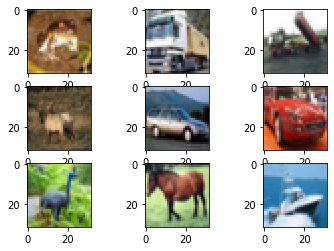

In [26]:
from keras.datasets import cifar10
from keras import backend as K

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')



for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(x_train[i])
# show the figure
plt.show()



x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# maximum value normalization
x_train /= 255
x_test /= 255

num_classes = 10
batch_size = 128

In the next cell, we set reshape the dataset to have the color channels in the place the backend require. Tensorflow requires "channels_last".

We also convert the labels to one-hot-encoded labels.

In [3]:
# Convert class vectors to binary class matrices.
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

img_rows, img_cols, channels = x_train.shape[1:]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(K.image_data_format())
print(input_shape)
print(y_train[0])

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)
channels_last
(32, 32, 3)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## Baseline: Multi-Layer Perceptron (MLP)

To get a baseline, we try a multi-layer perceptron: A model with a few hidden dense layers. If there are enough of those (>~3), the model can be considered deep.

In [5]:
def makeMLP(hidden = [512,512,256], activation = 'relu', input_shape=input_shape, num_classes=num_classes):
    model = Sequential()
    
    # converts the images (32x32x3) into vectors
    model.add(Flatten(input_shape=input_shape))
    model.add(BatchNormalization())
    for a in hidden:
        model.add(Dense(a, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [6]:
model = makeMLP()
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

W1009 13:17:13.711508 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1009 13:17:13.731914 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1009 13:17:13.873468 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1009 13:17:13.891180 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/k

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total params: 1,982,218
Trainable params: 1,976,074
Non-trainable params: 6,144
______________________________________________________________

Note, that this small MLP with three hidden layers of sizes 512, 512 and 256, already has about 2 million trainable parameters. The size of 512 activations is also not unreasonably large, as this already leads to a dimensional reduction of the input by a factor of 6.

In [7]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=20,
              validation_data=(x_test, y_test),
              shuffle=True)

W1009 13:17:14.081303 35184372383184 deprecation.py:323] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 10s 201us/step - loss: 1.7317 - acc: 0.3935 - val_loss: 1.5905 - val_acc: 0.4349
Epoch 2/20
50000/50000 [==============================] - 3s 59us/step - loss: 1.4779 - acc: 0.4783 - val_loss: 1.4781 - val_acc: 0.4788
Epoch 3/20
50000/50000 [==============================] - 3s 59us/step - loss: 1.3446 - acc: 0.5238 - val_loss: 1.4295 - val_acc: 0.5056
Epoch 4/20
50000/50000 [==============================] - 3s 58us/step - loss: 1.2357 - acc: 0.5617 - val_loss: 1.4345 - val_acc: 0.5078
Epoch 5/20
50000/50000 [==============================] - 3s 58us/step - loss: 1.1389 - acc: 0.5966 - val_loss: 1.4264 - val_acc: 0.5184
Epoch 6/20
50000/50000 [==============================] - 3s 58us/step - loss: 1.0546 - acc: 0.6249 - val_loss: 1.3587 - val_acc: 0.5345
Epoch 7/20
50000/50000 [==============================] - 3s 59us/step - loss: 0.9657 - acc: 0.6548 - val_loss: 1.4090 - val_a

We can note down, that the validation accuray maxes out at about 53%. This is not nothing, as with ten classed, pure guessing would give an accuracy of 10%.

It also starts overfitting quite quickly. This could be mitigated by using data augmentation and more regularization to an extent, which could also inprove the generalization somewhat. But we want to focus on the comparison with convnets here and thus will keep the other aspects simple. 

# Convolutional Neural Network

Let us no go to a very simple CNN. We compared to the previous MLP, we only replace the two larger hidden layers near the bottom by downsampling conv-layers. 



In [8]:
def makeCNN1(filters = (32, 64), dense = (256,), kernel_size=(3,3), activation='relu'
            , input_shape=input_shape, num_classes=num_classes, normAfterConv=False):
    model = Sequential()
    
    # using input layer to set input size explicitly, before we loop over layers
    model.add(BatchNormalization(input_shape=input_shape))
    
    for a in filters:
        model.add(Conv2D(a, kernel_size=kernel_size, activation=activation, strides=(2,2)))
        if normAfterConv:
            model.add(BatchNormalization())
    
    model.add(Flatten())
    
    for a in dense:
        model.add(Dense(a, activation=activation))
    
    model.add(Dense(num_classes, activation='softmax'))
       
    return model

In [9]:
model = makeCNN1()
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

W1009 13:18:20.475209 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               803072    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
Total params: 825,046
Trainable params: 825,040
Non-trainable params: 6
_________________________________________________________________


The concept of having conv layers 'looking' at the data and dense layers at the bottom interpreting the features found by the convolutional filters, has been used by early ImageNet-winning deep conv-nets.

Note, that this model only has ~825k trainable parameters, of which more than 800k are in the bottom dense layers.

In [10]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 8s 165us/step - loss: 1.5129 - acc: 0.4637 - val_loss: 1.3021 - val_acc: 0.5378
Epoch 2/10
50000/50000 [==============================] - 3s 58us/step - loss: 1.1093 - acc: 0.6090 - val_loss: 1.2293 - val_acc: 0.5704
Epoch 3/10
50000/50000 [==============================] - 3s 58us/step - loss: 0.8966 - acc: 0.6868 - val_loss: 0.9996 - val_acc: 0.6529
Epoch 4/10
50000/50000 [==============================] - 3s 58us/step - loss: 0.7216 - acc: 0.7494 - val_loss: 0.9986 - val_acc: 0.6602
Epoch 5/10
50000/50000 [==============================] - 3s 59us/step - loss: 0.5603 - acc: 0.8068 - val_loss: 1.0307 - val_acc: 0.6641
Epoch 6/10
50000/50000 [==============================] - 3s 58us/step - loss: 0.3959 - acc: 0.8638 - val_loss: 1.1614 - val_acc: 0.6610
Epoch 7/10
50000/50000 [==============================] - 3s 57us/step - loss: 0.2545 - acc: 0.9157 - val_loss: 1.3307 - val_ac

This model already reaches a validation accuracy of ~65%, about 10% more than our MLP. It seems to be even more prone to overfitting, however. This could be improved by adding more regularization.

### Pure Convnet

Let us try an (almost) pure convnet next. Basically, we eliminate the hidden dense layers completely and only retain the dens output layer, which uses the feature map generated by the conv layers and produces the prediction. We add more conv layers to improve the models abstraction ability and to produce a smaller featuremap at the bottom, which controls the input size of the final dense layer.

In [11]:
model = makeCNN1((32,64,96,96),[], normAfterConv=True)
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 96)          55392     
_________________________________________________________________
batch_normalization_6 (Batch (None, 3, 3, 96)          384       
__________

In [12]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 125us/step - loss: 1.4026 - acc: 0.4986 - val_loss: 1.2313 - val_acc: 0.5680
Epoch 2/10
50000/50000 [==============================] - 5s 101us/step - loss: 1.0169 - acc: 0.6407 - val_loss: 1.0167 - val_acc: 0.6393
Epoch 3/10
50000/50000 [==============================] - 5s 101us/step - loss: 0.8456 - acc: 0.7034 - val_loss: 0.9892 - val_acc: 0.6607
Epoch 4/10
50000/50000 [==============================] - 5s 101us/step - loss: 0.7171 - acc: 0.7481 - val_loss: 0.9252 - val_acc: 0.6858
Epoch 5/10
50000/50000 [==============================] - 5s 101us/step - loss: 0.6127 - acc: 0.7865 - val_loss: 0.9757 - val_acc: 0.6773
Epoch 6/10
50000/50000 [==============================] - 5s 99us/step - loss: 0.5176 - acc: 0.8177 - val_loss: 0.9412 - val_acc: 0.6921
Epoch 7/10
50000/50000 [==============================] - 5s 100us/step - loss: 0.4375 - acc: 0.8484 - val_loss: 1.0199 - v

This mode is only marginally better, but note, that now we only need ~169k parameters to get the same result.

### Small Darknet

The previous CNNs took some inspiration from an architecture called darknet, which is used in the YOLO approach to object detection [https://pjreddie.com/darknet/yolo/] .

The inspired part is increasing the number of filters after downsamling, but there is more to the to that architecture. So let us try this correctly, but smaller.

In [13]:
def makeSmallDarknet(nunits=3, nfilters0=16, kernel_size=(3,3), activation='relu'
                     , input_shape=input_shape, num_classes=num_classes):
    model = Sequential()
    
    model.add(Conv2D(nfilters0, kernel_size=kernel_size, activation=activation
                     , input_shape=input_shape, padding="same"))
    
    for a in range(1,nunits+1):
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        nfilters = int(nfilters0*(2**a))
        for s in range(a//2):
            model.add(Conv2D(nfilters, kernel_size=kernel_size, activation=activation, padding="same"))
            model.add(Conv2D(nfilters//2, kernel_size=(1,1), activation=activation))
        model.add(Conv2D(nfilters, kernel_size=kernel_size, activation=activation, padding="same"))
        
    model.add(Conv2D(num_classes, kernel_size=(1,1), activation=activation))
    model.add(GlobalAveragePooling2D())
    model.add(Softmax())
    
    return model

In [14]:
model = makeSmallDarknet()
model.summary()

opt = keras.optimizers.adam(lr=0.0001, decay=1e-6)

model.compile(loss=keras.losses.categorical_crossentropy,
              #optimizer=opt,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

W1009 13:19:48.149439 35184372383184 deprecation_wrapper.py:119] From /software/ml/JupyterHub/conda-env-20191018-0822/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 32)          128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 64)          18496     
__________

In [15]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 135us/step - loss: 1.4643 - acc: 0.4576 - val_loss: 1.4848 - val_acc: 0.4747
Epoch 2/10
50000/50000 [==============================] - 5s 109us/step - loss: 1.0270 - acc: 0.6304 - val_loss: 1.0252 - val_acc: 0.6355
Epoch 3/10
50000/50000 [==============================] - 5s 107us/step - loss: 0.8430 - acc: 0.6997 - val_loss: 1.0513 - val_acc: 0.6323
Epoch 4/10
50000/50000 [==============================] - 5s 108us/step - loss: 0.7329 - acc: 0.7410 - val_loss: 1.0094 - val_acc: 0.6664
Epoch 5/10
50000/50000 [==============================] - 5s 108us/step - loss: 0.6475 - acc: 0.7704 - val_loss: 0.9127 - val_acc: 0.6821
Epoch 6/10
50000/50000 [==============================] - 5s 108us/step - loss: 0.5783 - acc: 0.7943 - val_loss: 0.9034 - val_acc: 0.6949
Epoch 7/10
50000/50000 [==============================] - 5s 108us/step - loss: 0.5189 - acc: 0.8162 - val_loss: 0.8925 - 

This model can us ~70% in validation accuracy, but since we are not augmenting the data here it also starts to overfit quickly.

Using data augmentation, it can reach >80%, but this takes a while.

In [16]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_generator = train_datagen.flow(x_train, y_train,
    batch_size=batch_size)

In [17]:
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=50000 // batch_size,
        epochs=50,
        validation_data=(x_test, y_test))

Epoch 1/50
390/390 [==============================] - 28s 72ms/step - loss: 0.9164 - acc: 0.6822 - val_loss: 0.9234 - val_acc: 0.6988
Epoch 2/50
390/390 [==============================] - 28s 71ms/step - loss: 0.8542 - acc: 0.7016 - val_loss: 0.9049 - val_acc: 0.7016
Epoch 3/50
390/390 [==============================] - 28s 72ms/step - loss: 0.8137 - acc: 0.7162 - val_loss: 0.9595 - val_acc: 0.6909
Epoch 4/50
390/390 [==============================] - 28s 71ms/step - loss: 0.7829 - acc: 0.7274 - val_loss: 1.0539 - val_acc: 0.6635
Epoch 5/50
390/390 [==============================] - 28s 71ms/step - loss: 0.7645 - acc: 0.7326 - val_loss: 0.7660 - val_acc: 0.7360
Epoch 6/50
390/390 [==============================] - 28s 71ms/step - loss: 0.7460 - acc: 0.7400 - val_loss: 1.6300 - val_acc: 0.5051
Epoch 7/50
390/390 [==============================] - 28s 73ms/step - loss: 0.7235 - acc: 0.7485 - val_loss: 0.6571 - val_acc: 0.7725
Epoch 8/50
390/390 [==============================] - 28s 73ms

In [18]:
model.save_weights("darknet.h5")

### Getting and displaying the feature map

In [19]:
def makeSmallDarknetFkt(nunits=3, nfilters0=16, kernel_size=(3,3), activation='relu'
                     , input_shape=input_shape, num_classes=num_classes):
    model = Sequential()
    
    model.add(Conv2D(nfilters0, kernel_size=kernel_size, activation=activation
                     , input_shape=input_shape, padding="same"))
    
    for a in range(1,nunits+1):
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        nfilters = int(nfilters0*(2**a))
        for s in range(a//2):
            model.add(Conv2D(nfilters, kernel_size=kernel_size, activation=activation, padding="same"))
            model.add(Conv2D(nfilters//2, kernel_size=(1,1), activation=activation))
        model.add(Conv2D(nfilters, kernel_size=kernel_size, activation=activation, padding="same"))
    
    model.add(Conv2D(num_classes, kernel_size=(1,1), activation=activation))
    modelTop = Sequential()
    modelTop.add(GlobalAveragePooling2D(input_shape=model.output_shape[1:]))
    modelTop.add(Softmax())
    
    modelFull = Model(inputs=model.input, 
              outputs=modelTop(model.output))
    
    return modelFull, model

In [20]:
modelF, modelM = makeSmallDarknetFkt()
modelF.summary()

opt = keras.optimizers.adam(lr=0.01, decay=1e-6)

modelF.compile(loss=keras.losses.categorical_crossentropy,
              #optimizer=opt,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16_input (InputLayer) (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 8, 8, 32)          128       
__________

In [21]:
hist = modelF.fit_generator(
        train_generator,
        steps_per_epoch=50000 // batch_size,
        epochs=10,
        validation_data=(x_test, y_test))

Epoch 1/10
390/390 [==============================] - 29s 74ms/step - loss: 1.6567 - acc: 0.3891 - val_loss: 1.6982 - val_acc: 0.4573
Epoch 2/10
390/390 [==============================] - 28s 73ms/step - loss: 1.2745 - acc: 0.5421 - val_loss: 1.4112 - val_acc: 0.5290
Epoch 3/10
390/390 [==============================] - 29s 74ms/step - loss: 1.1269 - acc: 0.5974 - val_loss: 1.0296 - val_acc: 0.6376
Epoch 4/10
390/390 [==============================] - 27s 69ms/step - loss: 1.0258 - acc: 0.6377 - val_loss: 1.1923 - val_acc: 0.6077
Epoch 5/10
390/390 [==============================] - 28s 71ms/step - loss: 0.9563 - acc: 0.6634 - val_loss: 1.0035 - val_acc: 0.6573
Epoch 6/10
390/390 [==============================] - 28s 73ms/step - loss: 0.9072 - acc: 0.6804 - val_loss: 0.9322 - val_acc: 0.6810
Epoch 7/10
390/390 [==============================] - 28s 73ms/step - loss: 0.8643 - acc: 0.6971 - val_loss: 0.9810 - val_acc: 0.6699
Epoch 8/10
390/390 [==============================] - 29s 74ms

In [22]:
modelF.load_weights("darknet.h5")

In [23]:
def showMaps(idx, model, data, preproc= None, cols=5):
    try:
        idx = list(idx)
    except:
        idx = [idx]
        
    data = data[idx]
        
    p = model[0].predict(data if preproc is None else preproc(data))
    m = model[1].predict(data if preproc is None else preproc(data))
    m = np.argmax(m, axis=3)
    print(m.shape)
    
    ncats = 0
    ndogs = 0
    nother = 0
    
    i=0
    labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
    while i < p.shape[0]:
        fig, axs = plt.subplots(2,cols,figsize=(5*cols,5))
        fig.figsize=(20,10)
        for ax, axM in zip(axs[0], axs[1]):
            ax.imshow(data[i])
            axM.imshow(m[i],vmin=0, vmax=len(labels)-1, interpolation="none")
            label = np.argsort(p[i])[-1]
            ax.text(.5,0, labels[label]+", score "+str(p[i][label]),
                    horizontalalignment='center', verticalalignment='bottom', transform=ax.axes.transAxes,
                    backgroundcolor="white", size="large")
            i += 1
            if i >= p.shape[0]:
                break
            
        plt.show()

(20, 4, 4)


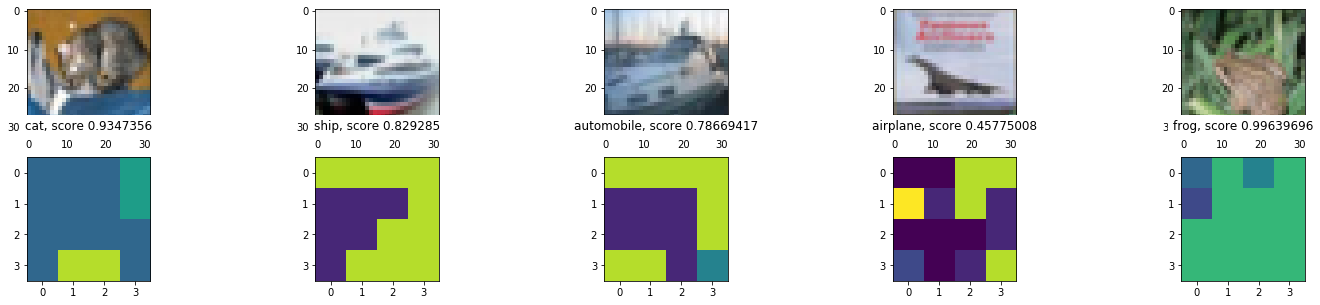

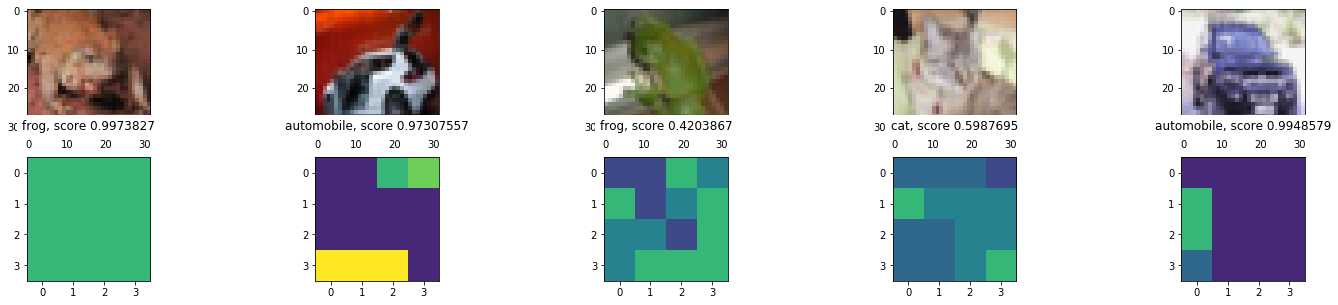

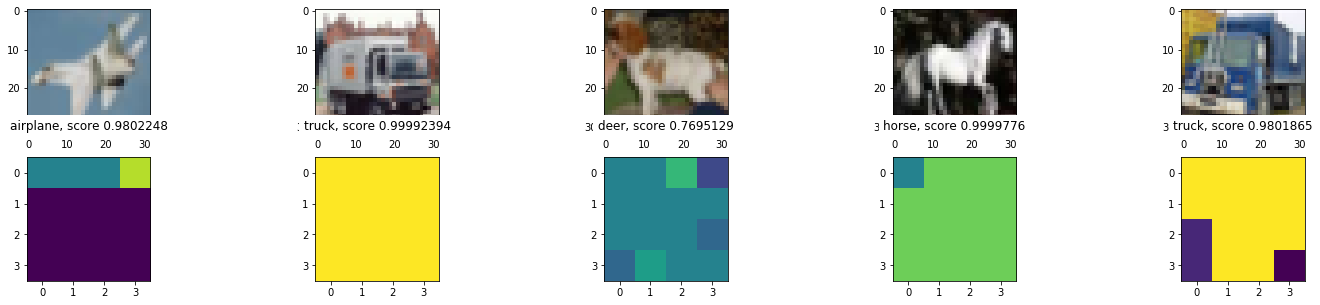

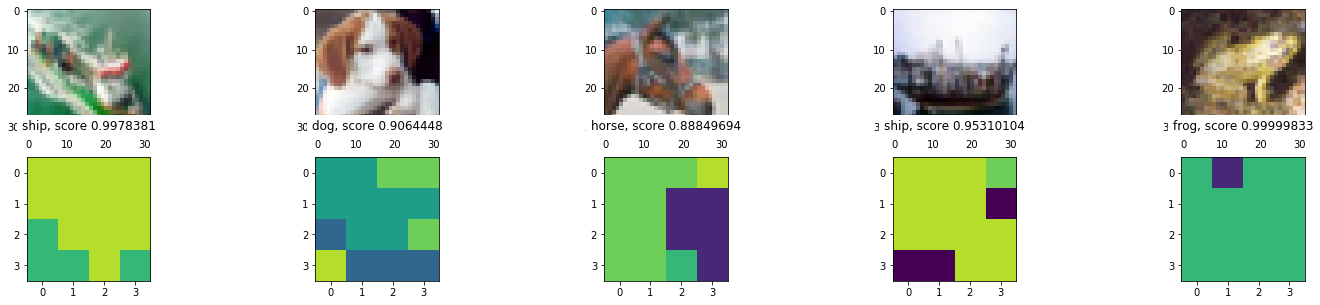

In [24]:
showMaps(range(20), (modelF,modelM), x_test)